<a href="https://colab.research.google.com/github/niedakaito/EU_M_Math/blob/main/Chap08_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# chapter 8-1 機械学習の全体像

In [1]:
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn

# 小数第3位まで表示
%precision 3

'%.3f'

# chapter 8-2 重回帰

In [2]:
import requests, zipfile
import io

# 自動車価格データを取得
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
res = requests.get(url).content

# 取得したデータをDataFrameオブジェクトとして読み込み
auto = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

# データの列にラベルを設定
auto.columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors',
                'body-style', 'dribe-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height',
                'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore',
                'stroke', 'compression-ratio', 'horsepower', 'perk-rpm' , 'city-mpg', 'highway-mpg', 'price']

In [3]:
print('自動車データの形式:{}'.format(auto.shape))

自動車データの形式:(205, 26)


In [4]:
auto.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,dribe-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,perk-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [5]:
# それぞれのカラムに?が何個あるかカウント
auto = auto[['price', 'horsepower', 'width', 'height']]
auto.isin(['?']).sum()

price         4
horsepower    2
width         0
height        0
dtype: int64

In [6]:
# ?をNaNに置換して、NaNがある行を削除
auto = auto.replace('?', np.nan).dropna()
print('自動車データの形式:{}'.format(auto.shape))

自動車データの形式:(199, 4)


In [7]:
print('データ型の確認（型変換前）\n{}'.format(auto.dtypes))

データ型の確認（型変換前）
price          object
horsepower     object
width         float64
height        float64
dtype: object


In [8]:
auto = auto.assign(price = pd.to_numeric(auto.price))
auto = auto.assign(horsepower = pd.to_numeric(auto.horsepower))
print('データ型の確認（型変換後）\n{}'.format(auto.dtypes))

データ型の確認（型変換後）
price           int64
horsepower      int64
width         float64
height        float64
dtype: object


In [9]:
auto.corr()

,price,horsepower,width,height
price,1.000000,0.810533,0.753871,0.134990
horsepower,0.810533,1.000000,0.615315,-0.087407
width,0.753871,0.615315,1.000000,0.309223
height,0.134990,-0.087407,0.309223,1.000000


In [10]:
# データ分割（訓練データとテストデータ）のためのインポート
from sklearn.model_selection import train_test_split

# 重回帰のモデル構築のためのインポート
from sklearn.linear_model import LinearRegression

# 目的変数にpriceを指定、説明変数にそれ以外を指定
X = auto.drop('price', axis=1)
y = auto['price']

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# 重回帰クラスの初期化と学習
model = LinearRegression()
model.fit(X_train, y_train)

# 決定係数を表示
print('決定係数(train):{:.3f}'.format(model.score(X_train, y_train)))
print('決定係数(test):{:.3f}'.format(model.score(X_test, y_test)))

# 回帰係数と切片を表示
print('\n回帰係数\n{}'.format(pd.Series(model.coef_, index=X.columns)))
print('切片:{:.3f}'.format(model.intercept_))

決定係数(train):0.733
決定係数(test):0.737

回帰係数
horsepower      81.651078
width         1829.174506
height         229.510077
dtype: float64
切片:-128409.046


# chapter 8-4 正則化項のある回帰：ラッソ回帰、リッジ回帰

In [11]:
auto.head()

,price,horsepower,width,height
0,13495,111,64.1,48.8
1,16500,111,64.1,48.8
2,16500,154,65.5,52.4
3,13950,102,66.2,54.3
4,17450,115,66.4,54.3


In [12]:
# リッジ回帰用のクラス
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# 訓練データとテストデータに分類
X = auto.drop('price', axis=1)
y = auto['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# モデルの構築と評価
linear = LinearRegression()
ridge = Ridge(random_state=0)

for model in [linear, ridge]:
  model.fit(X_train, y_train)
  print('{}(train):{:6f}'.format(model.__class__.__name__, model.score(X_train, y_train)))
  print('{}(test):{:6f}'.format(model.__class__.__name__, model.score(X_test, y_test)))

LinearRegression(train):0.733358
LinearRegression(test):0.737069
Ridge(train):0.733355
Ridge(test):0.737768


# chapter 8-5 決定木

In [13]:
# データ取得
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
res = requests.get(url).content

# 取得したデータをDataFrameオブジェクトとして読み込み
mushroom = pd.read_csv(io.StringIO(res.decode('utf-8')), header=None)

mushroom.columns = ['classes','cap_shape','cap_surface','cap_color','bruises','odor',
                    'gill_attachment','gill_spacing','gill_size','gill_color','stalk_shape',
                    'stalk_root','stalk_surface_above_ring','stalk_surface_below_ring',
                    'stalk_color_above_ring','stalk_color_below_ring','veil_type','veil_color',
                    'ring_number','ring_type','spore_print_color','population','habitat']

# 先頭5行を表示
mushroom.head()

,classes,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [14]:
print('データの形式:{}'.format(mushroom.shape))
print('欠損の数:{}'.format(mushroom.isnull().sum().sum()))

データの形式:(8124, 23)
欠損の数:0


In [15]:
mushroom_dummy = pd.get_dummies(mushroom[['gill_color','gill_attachment','odor','cap_color']])
mushroom_dummy.head()

,gill_color_b,gill_color_e,gill_color_g,gill_color_h,gill_color_k,gill_color_n,gill_color_o,gill_color_p,gill_color_r,gill_color_u,...,cap_color_b,cap_color_c,cap_color_e,cap_color_g,cap_color_n,cap_color_p,cap_color_r,cap_color_u,cap_color_w,cap_color_y
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [16]:
# 目的変数もフラグ化（0/1化）する
mushroom_dummy['flg'] = mushroom['classes'].map(lambda x: 1 if x == 'p' else 0)

In [17]:
mushroom_dummy.groupby(['cap_color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap_color_c,,
False,4176,3904
True,32,12


In [18]:
mushroom_dummy.groupby(['gill_color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill_color_b,,
False,4208.0,2188.0
True,NaN,1728.0


In [19]:
- (0.5 * np.log2(0.5) + 0.5 * np.log2(0.5))

1.0

In [20]:
- (0.001 * np.log2(0.001) + 0.999 * np.log2(0.999))

0.011407757737461138

In [21]:
def calc_entropy(p):
  return - (p * np.log2(p) + (1 - p) * np.log2(1 - p))

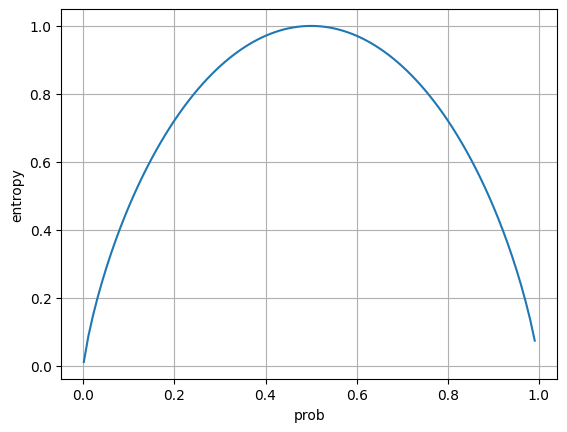

In [22]:
# pの値を0.001から0.999まで0.01刻みで動かす
p = np.arange(0.001, 0.999, 0.01)

# グラフか
plt.plot(p, calc_entropy(p))
plt.xlabel('prob')
plt.ylabel('entropy')
plt.grid(True)

In [23]:
mushroom_dummy.groupby('flg')['flg'].count()

flg
0    4208
1    3916
Name: flg, dtype: int64

In [24]:
entropy_init = - (0.518 * np.log2(0.518) + 0.482 * np.log2(0.482))
print('毒キノコデータのエントロピーの初期値:{:.3f}'.format(entropy_init))

毒キノコデータのエントロピーの初期値:0.999


In [25]:
mushroom_dummy.groupby(['cap_color_c', 'flg'])['flg'].count().unstack()

flg,0,1
cap_color_c,,
False,4176,3904
True,32,12


In [26]:
# cap_colorがcでない場合のエントロピー
p1 = 4176 / (4176 + 3904)
p2 = 1 - p1
entropy_c0 = -(p1 * np.log2(p1) + p2 * np.log2(p2))
print('entropy_c0: {:.3f}'.format(entropy_c0))

entropy_c0: 0.999


In [27]:
# cap_colorがcである場合のエントロピー
p1 = 32 / (32 + 12)
p2 = 1 - p1
entropy_c1 = -(p1 * np.log2(p1) + p2 * np.log2(p2))
print('entropy_c1: {:.3f}'.format(entropy_c1))

entropy_c1: 0.845


In [28]:
entropy_after = (4176 + 3904) / 8124 * entropy_c0 + (32 + 12) / 8124 * entropy_c1
print('データ分割後の平均エントロピー: {:.3f}'.format(entropy_after))

データ分割後の平均エントロピー: 0.998


In [29]:
print('変数cap_colorの分割によって得られる情報利得: {:.3f}'.format(entropy_init - entropy_after))

変数cap_colorの分割によって得られる情報利得: 0.001


In [30]:
mushroom_dummy.groupby(['gill_color_b', 'flg'])['flg'].count().unstack()

flg,0,1
gill_color_b,,
False,4208.0,2188.0
True,NaN,1728.0


In [31]:
# gill_colorがbでない場合のエントロピー
p1 = 4208 / (4208 + 2188)
p2 = 1 - p1
entropy_b0 = - (p1 * np.log2(p1) + p2 * np.log2(p2))

# gill_colorがbである場合のエントロピー
p1 = 0 / (0 + 1728)
p2 = 1 - p1
entropy_b1 = -(p2 * np.log(p2))

entropy_after = (4208 + 2188) / 8124 * entropy_b0 + (0 + 1728) / 8124 * entropy_b1
print('変数gill_colorの分割によって得られる情報利得: {:.3f}'.format(entropy_init - entropy_after))

変数gill_colorの分割によって得られる情報利得: 0.269


In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# データ分析
X = mushroom_dummy.drop('flg', axis=1)
y = mushroom_dummy['flg']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 決定木クラスの初期化と学習
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
model.fit(X_train, y_train)

print('正解率(train):{:.3f}'.format(model.score(X_train, y_train)))
print('正解(test):{:.3f}'.format(model.score(X_test, y_test)))

正解率(train):0.991
正解(test):0.992


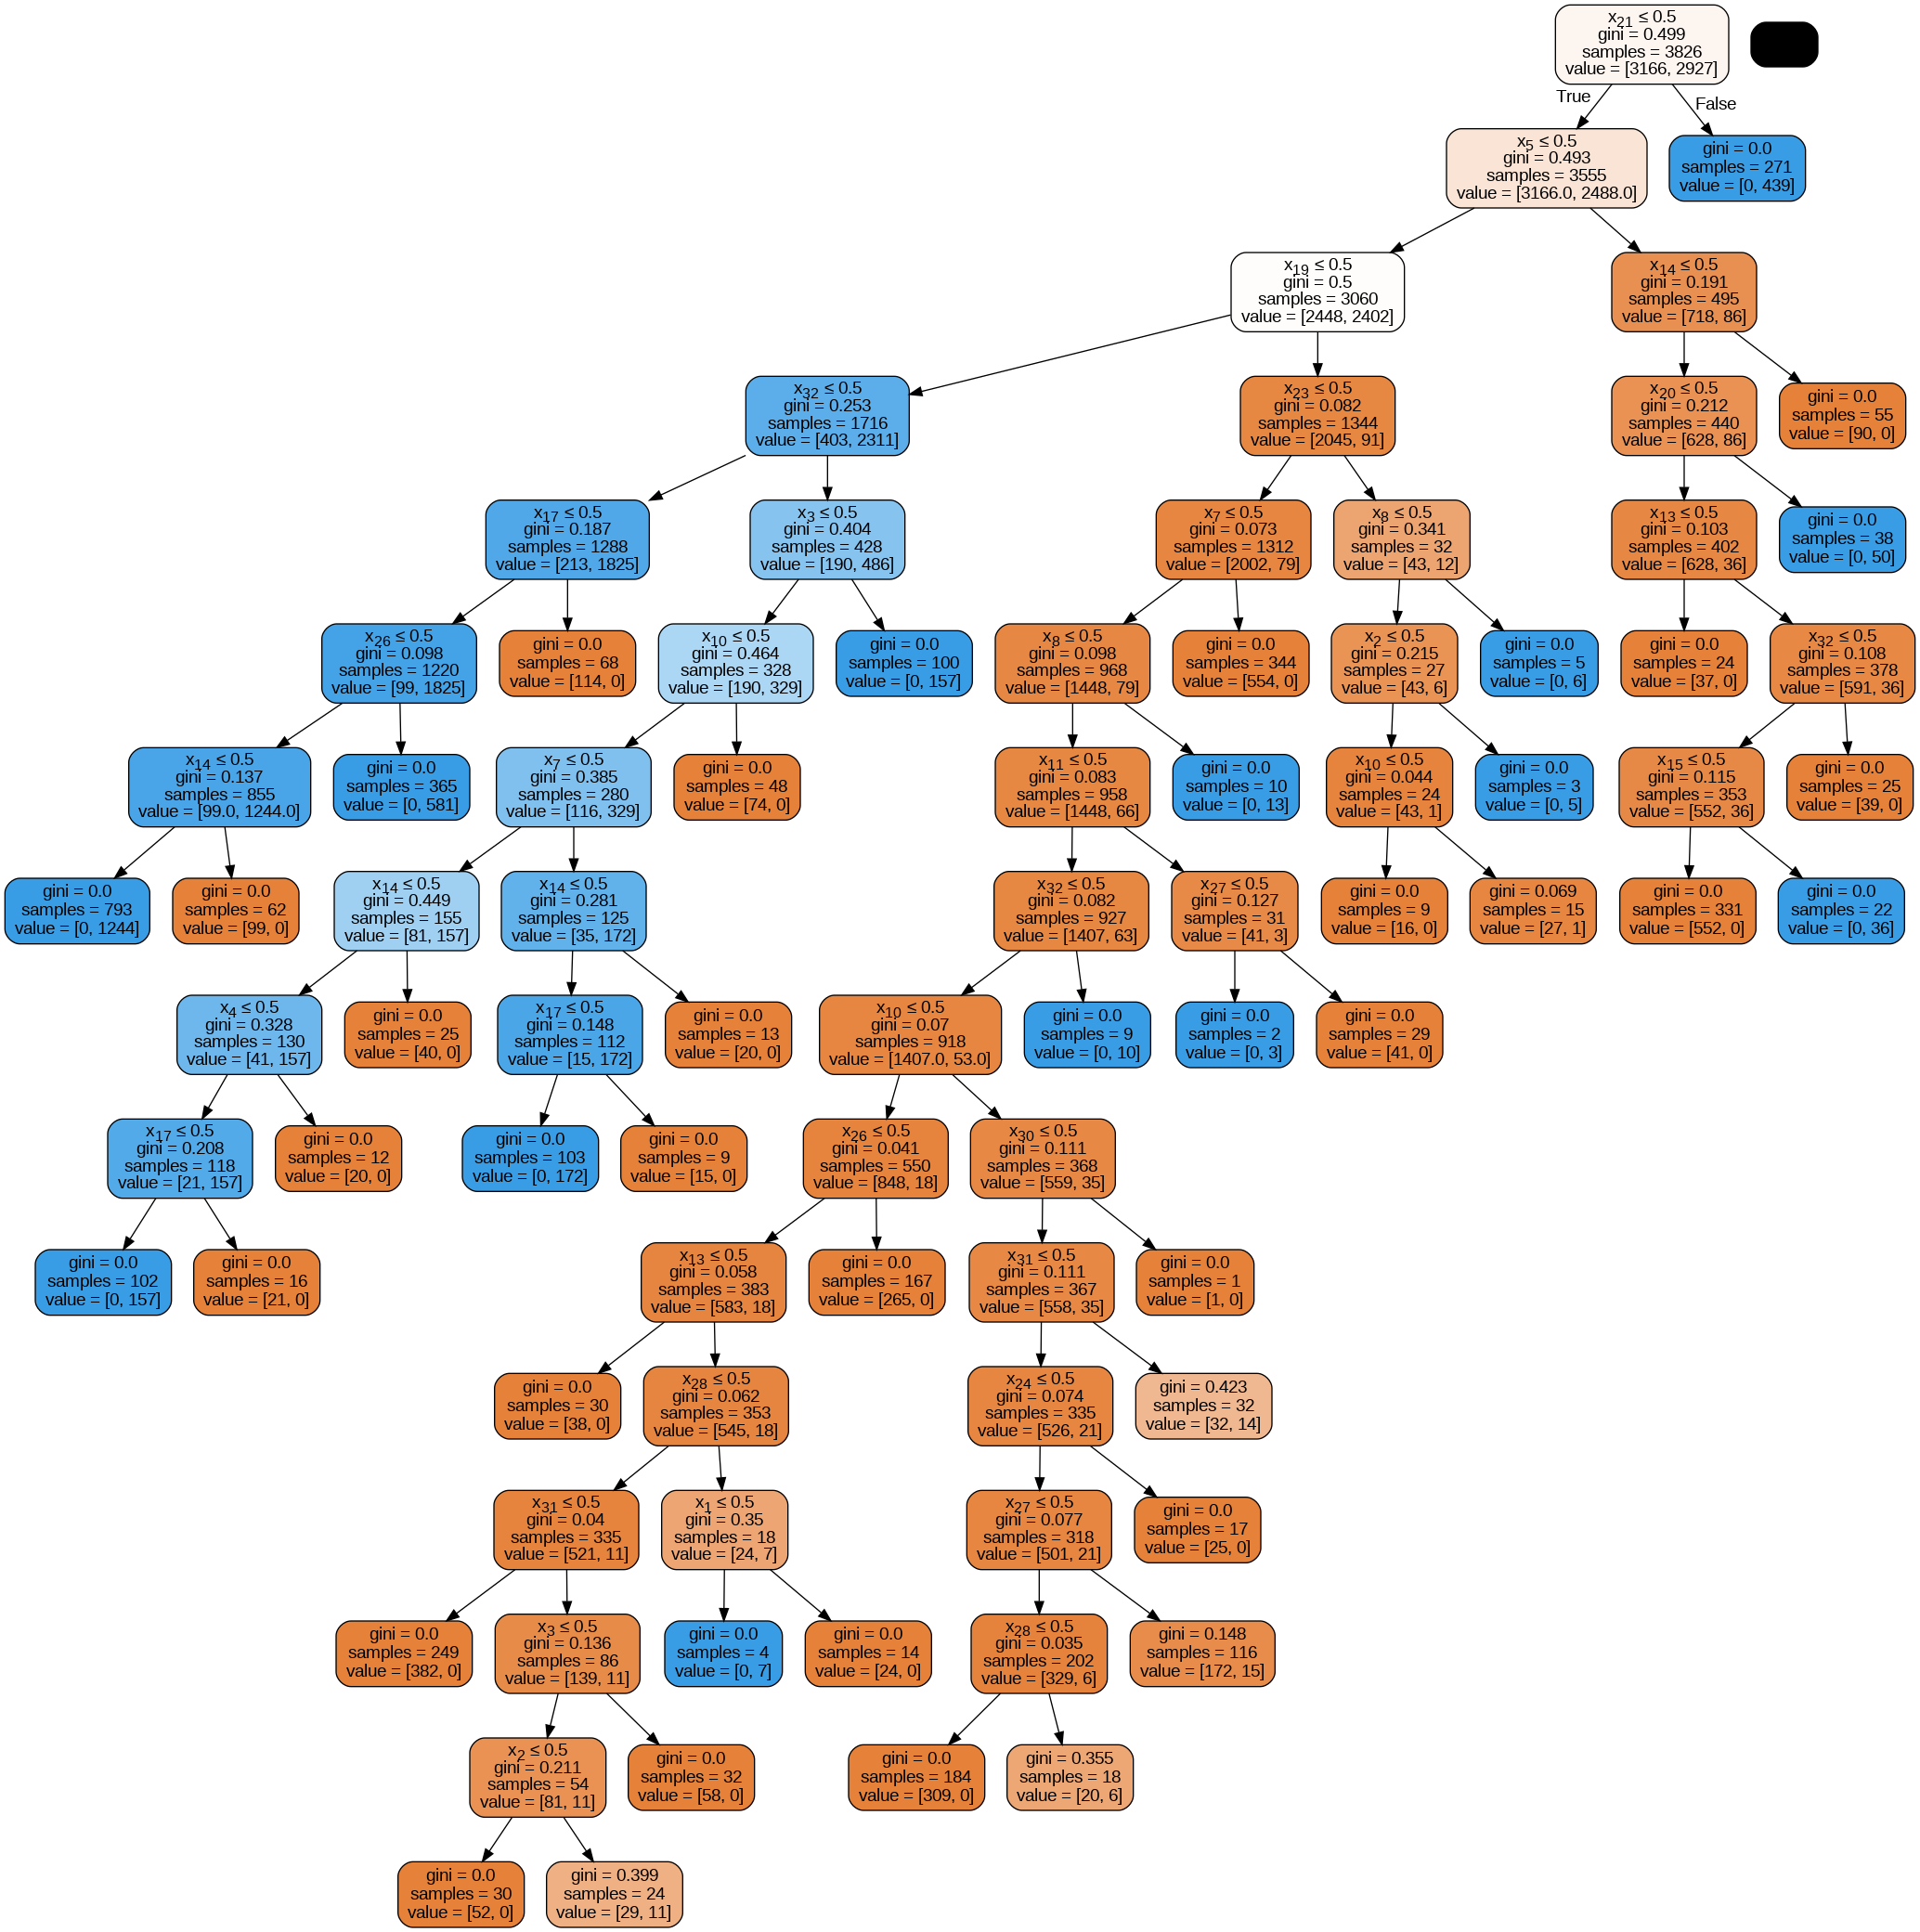

In [33]:
# 参考プログラム
# pydotplusやgraphvizをインストールする必要があります(google Colaborator上ではインストール不要)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from six import StringIO

# ランダムフォレストモデルを作成
model = RandomForestClassifier(n_estimators=1)
model.fit(X_train, y_train)

# 最初の決定木を取り出して可視化
dot_data = StringIO()
export_graphviz(model.estimators_[0], out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


# chapter 8-7 サポートベクターマシン

In [34]:
!pip install --upgrade scikit-learn

In [39]:
# データやモデルを構築するためのライブラリなどのインポート
from sklearn.datasets import load_breast_cancer

# SVMのライブラリ
from sklearn.svm import LinearSVC

# 訓練データとテストデータを分けるライブラリ
from sklearn.model_selection import train_test_split

# データの読み込み
cancer =load_breast_cancer()

# 訓練データとテストデータに分ける
X_tarin, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify = cancer.target, random_state=0)

# クラスの初期化と学習
model = LinearSVC(random_state=0)
model.fit(X_tarin, y_train)

# 訓練データとテストデータのスコア
print('正解率(train):{:.3f}'.format(model.score(X_tarin, y_train)))
print('正解率(test):{:.3f}'.format(model.score(X_test, y_test)))

正解率(train):0.972
正解率(test):0.937


In [45]:
from sklearn.preprocessing import StandardScaler

# データの読み込み
cancer = load_breast_cancer()

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# クラスの初期化と学習
model = LinearSVC(random_state=0)
model.fit(X_train_std, y_train)

# 訓練データとテストデータのスコア
print('正解率(train): {:.3f}'.format(model.score(X_train_std, y_train)))
print('正解率(test): {:.3f}'.format(model.score(X_test_std, y_test)))


正解率(train): 0.993
正解率(test): 0.951
